In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from read_json import read_json  # for json files
import numpy as np
from plots import plot_histogram
from datetime import datetime
from scipy import stats
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree
import time
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
qaserver = pd.read_csv('./resampled/qaserver_resampled.csv')
times = np.array(qaserver['@timestamp'])

In [3]:
qaserver['mem_cpu'] = qaserver['actual_used_pct'] / (qaserver['user_pct'] + qaserver['system_pct'])

In [4]:
qaserver['algo'] = (qaserver['free']  / qaserver['bytes_total']) / (qaserver['user_pct'])

(array([ 38., 204., 205., 243.,  91.,  96.,  56.,  35.,  34.,  40.,  27.,
         27.,  32.,  31.,  13.,  26.,  19.,  21.,   9.,  14.,   4.,   7.,
          4.,   5.,   2.,   1.,   2.,   2.,   0.,   1.]),
 array([ 0.61243771,  3.12748979,  5.64254187,  8.15759394, 10.67264602,
        13.1876981 , 15.70275017, 18.21780225, 20.73285432, 23.2479064 ,
        25.76295848, 28.27801055, 30.79306263, 33.3081147 , 35.82316678,
        38.33821886, 40.85327093, 43.36832301, 45.88337509, 48.39842716,
        50.91347924, 53.42853131, 55.94358339, 58.45863547, 60.97368754,
        63.48873962, 66.0037917 , 68.51884377, 71.03389585, 73.54894792,
        76.064     ]),
 <BarContainer object of 30 artists>)

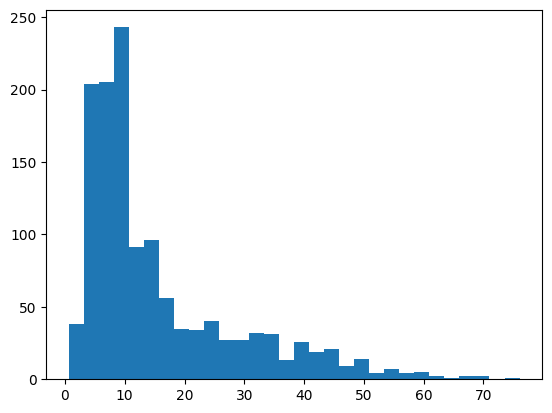

In [5]:
mem_cpu = np.array(qaserver['mem_cpu'])
mem_cpu = mem_cpu[~np.isnan(mem_cpu) * ~np.isinf(mem_cpu)]
plt.hist(mem_cpu, bins=30, log=False)

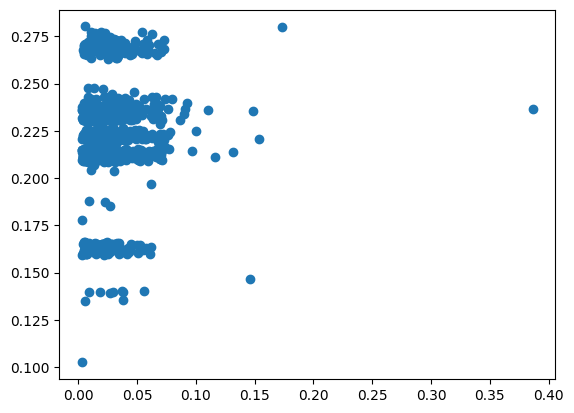

In [6]:
scat = plt.scatter(qaserver['user_pct'] + qaserver['system_pct'], qaserver['actual_used_pct'])
offsets = scat.get_offsets()

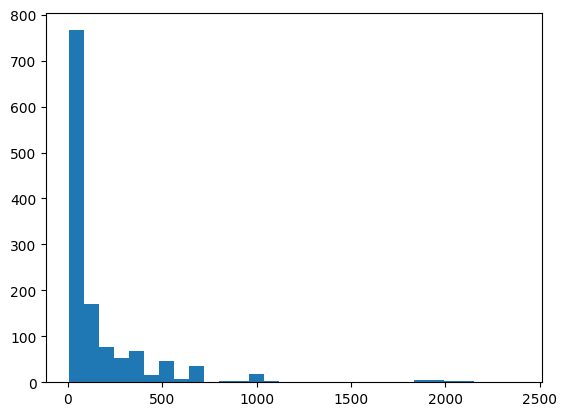

In [7]:
algo = np.array(qaserver['algo'])
algo = algo[~np.isnan(algo) *  ~np.isinf(algo)]
algo_data = plt.hist(algo, bins=30, log=False)

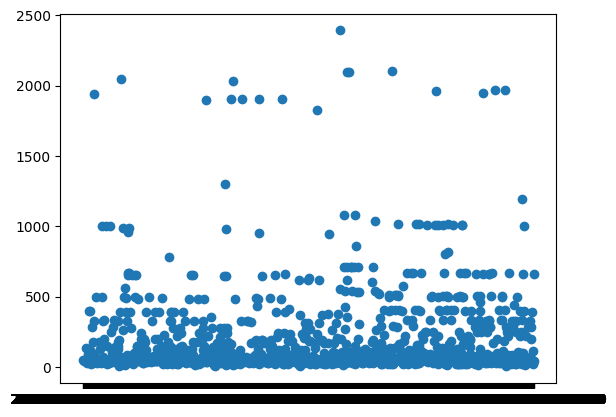

In [9]:
algo = np.array(qaserver['algo'])
plt.scatter(times, algo)

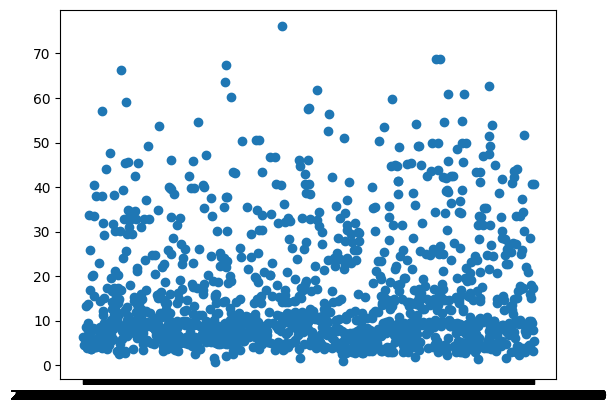

In [10]:
mem_cpu = np.array(qaserver['mem_cpu'])
plt.scatter(times, mem_cpu)

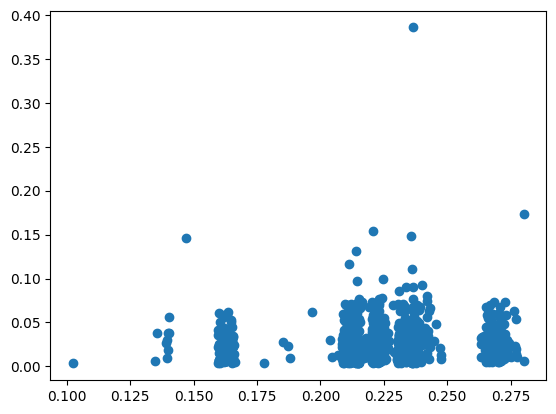

In [86]:
plt.scatter(qaserver['actual_used_pct'], (qaserver['user_pct'] + qaserver['system_pct']))

## K means

In [54]:
def convert_timestamp(ts):
    conversions = []

    for t in ts:
        timestamp = datetime.strptime(t, "%Y-%m-%d %H:%M:%S").timestamp()
        conversions.append(timestamp)

    return np.array(conversions)

In [180]:
# filter = ~np.isnan(algo) *  ~np.isinf(algo)

# algo_filtered = algo[filter]
# time_filtered = times[filter]
# time_filtered = convert_timestamp(time_filtered)

memory = qaserver['actual_used_pct']  
cpu = (qaserver['user_pct'] + qaserver['system_pct'])
filter = ~np.isnan(cpu) *  ~np.isinf(cpu)

memory = memory[filter]
cpu = cpu[filter]

filter2 = ~np.isnan(memory) *  ~np.isinf(memory)

memory = memory[filter2]
cpu = cpu[filter2]


# for t in time_filtered:
#     date = datetime.strptime(t, "%Y-%m-%d %H:%M:%S").timestamp()
#     print(date)
# X = np.vstack([algo_filtered, time_filtered]).T
X = np.vstack([memory, cpu]).T


nbrs = NearestNeighbors(n_neighbors=7).fit(X)
distances, indices = nbrs.kneighbors(X)

# plt.scatter(time, algo)

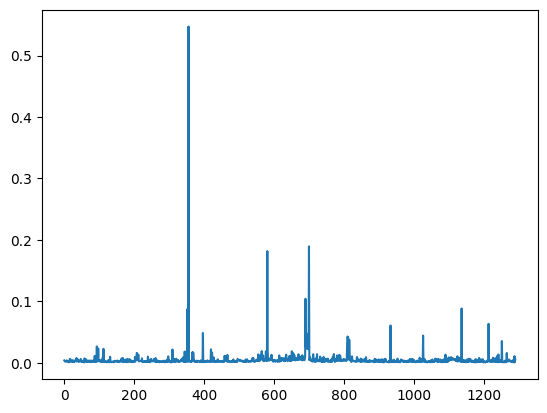

In [181]:
promedios = distances.mean(axis = 1)
plt.plot(promedios)

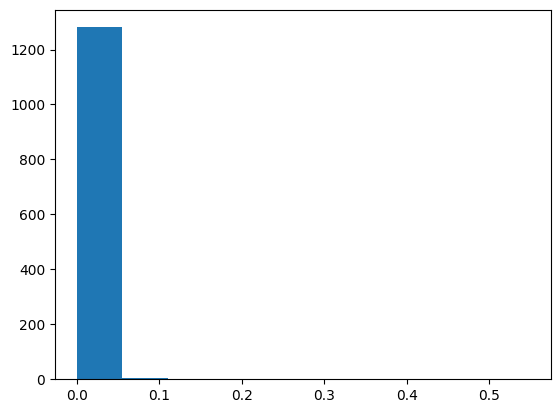

In [196]:
plt.hist(promedios, bins=10)
alpha, fit_loc, beta=stats.gamma.fit(promedios)
desv_est = np.std(promedios)

In [199]:
outlier_index = np.where(promedios > 5 * desv_est)
outlier_index = outlier_index[0].tolist()
outlier_index

[355, 580, 689, 699]

In [200]:
outlier_memory = memory.iloc[outlier_index]
outlier_cpu = cpu.iloc[outlier_index]
# outlier_values = memory.iloc[outlier_index]
# outlier_times = time_filtered[outlier_index]

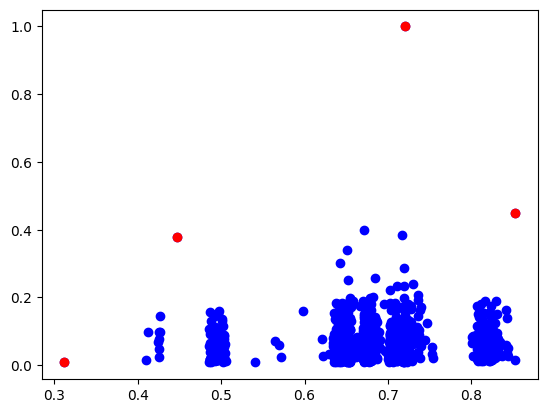

In [201]:
plt.scatter(memory, cpu, color="b")
plt.scatter(outlier_memory, outlier_cpu, color = "r")

## Pipeline

In [203]:
def outliers_from_neighbors(data_1, data_2):
    # Filtros de nans e infs
    filter = ~np.isnan(data_1) *  ~np.isinf(data_1)
    data_1 = data_1[filter]
    data_2 = data_2[filter]

    filter_2 = ~np.isnan(data_2) *  ~np.isinf(data_2)

    data_1 = data_1[filter_2]
    data_2 = data_2[filter_2]

    # Agrupar
    X = np.vstack([memory, cpu]).T

    # Nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=7).fit(X)
    distances, indices = nbrs.kneighbors(X)

    # Promedio de distancias
    promedios = distances.mean(axis = 1)

    # Desv est
    desv_est = np.std(promedios)

    # Outliers
    outlier_index = np.where(promedios > 5 * desv_est)
    outlier_index = outlier_index[0].tolist()

    outlier_data_1 = data_1.iloc[outlier_index]
    outlier_data_2 = data_2.iloc[outlier_index]   

    # Return datas
    return outlier_data_1, outlier_data_2

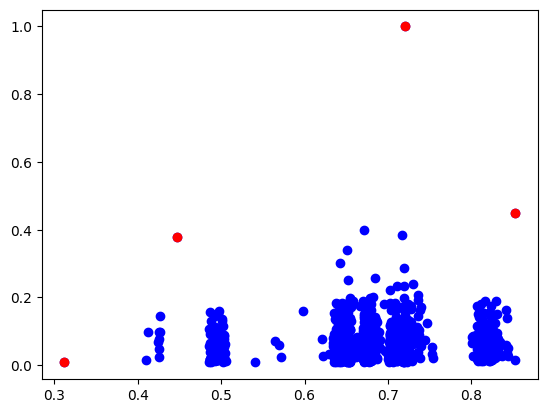

In [204]:
outlier_memory, outlier_cpu = outliers_from_neighbors(memory, cpu)
plt.scatter(memory, cpu, color="b")
plt.scatter(outlier_memory, outlier_cpu, color = "r")

1306    0.763396
2150    0.719890
2543    0.897550
2576    0.853129
dtype: float64

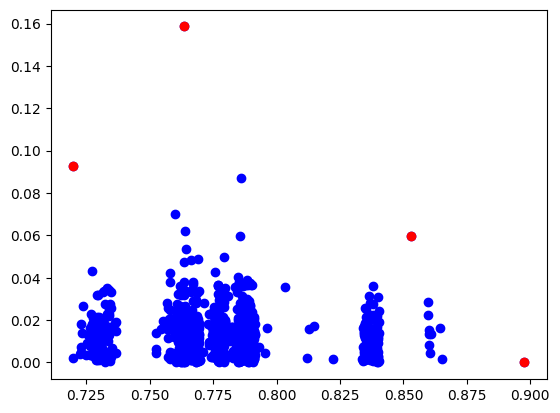

In [206]:
mem_free = (qaserver['free']  / qaserver['bytes_total']) 
user_cpu = (qaserver['user_pct'])
out_mem, out_cpu = outliers_from_neighbors(mem_free, user_cpu)
plt.scatter(mem_free, user_cpu, color="b")
plt.scatter(out_mem, out_cpu, color = "r")

out_mem

In [208]:
out_mem[1306]

0.7633960886965638